# Learning the VAE

In [2]:
import notebook.services.api.handlers
import pandas as pd

from models.helpers_talent import *
from models.VAE import *

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow_probability as tfp
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, mean_squared_error
import seaborn as sns
from sklearn.manifold import TSNE
plt.rcParams['figure.figsize'] = (15, 12)
import warnings
warnings.filterwarnings('ignore')
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

In [3]:
# <editor-fold desc="DATA">
group = 1           # age class 'AK'
test_size = 0.2     # train-test split
sub = False         # subjective meassures

dat0 = pd.read_csv('data/dat_vs1', sep=' ', index_col=False)
dat = dat0[dat0['AK'] == group]
dat = dat.drop('AK', axis=1).reset_index(drop=True)
if sub:
    c = 16
else:
    c = 14
X_0 = dat.iloc[:, 2:c]
y_0 = dat.iloc[:, 16]
X, X_test, y, y_test = train_test_split(X_0, y_0, test_size=test_size, random_state=42, stratify=y_0)
X_full = X_0.copy()
y_full = y_0.copy()

# english variable-names
X_names = ['birthday', 'height', 'weight', 'SL20', 'GW','DR','BK','BJ','SKSC_TAK','SKSC_TEC','SKSC_KON','SKSC_PSY']
X_full.columns = X_names
X.columns = X_names

save_dir_train = 'saved_models/tfp'
save_dir = 'saved_models/tfp_full'

X_full.loc[X_full['weight']>70,:]

# ___ SCALING
# MinMax [0,1]
scaler_train = StandardScaler().fit(X)
df_train = scaler_train.transform(X)
y_train = np.asarray(y)

# full
scaler = StandardScaler().fit(X_full)
df = scaler.transform(X_full)
y = np.asarray(y_full)
# scaler_test = StandardScaler().fit(X_test)
#df_test = scaler.transform(X_test)# </editor-fold>

### Models have been train for different latent dimensions and different beta values / or results of one model
Results are in the model_results file. For all models the following general architecture was used:

In [4]:
model_results = pd.read_csv(save_dir + '/model_results_search.csv', index_col=False)
print(model_results[model_results['latent_dim']==4].iloc[0,1:3])

inter1_dim    8
inter2_dim    0
Name: 17, dtype: object


In [5]:
dim_temp = 7
model_results[model_results['latent_dim']==dim_temp].iloc[:,3:]

,latent_dim,beta,learning_rate,elbo,mean_loglik,mean_KL
68,7,0.3,0.01,9.516180,-0.670814,18337.984000
69,7,0.4,0.01,12.854229,4.643577,2864.817600
70,7,0.5,0.01,14.671657,11.820393,17.960512
71,7,0.6,0.01,15.184290,12.440948,10.708836
72,7,0.7,0.01,15.745624,13.910258,5.255282
73,7,0.8,0.01,16.015132,14.284829,4.017300
74,7,0.9,0.01,16.252504,14.569615,2.959504
75,7,1.0,0.01,16.414075,14.872329,2.255479
76,7,1.1,0.01,16.644456,15.621069,1.162065
77,7,1.2,0.01,16.712130,15.744101,0.908155


### Model selection

Load beta - loss dict for one number of latent dimensions

In [6]:
#beta_loss = pd.read_csv(save_dir + '/beta_loss.csv', index_col=False)
beta_loss = model_results[model_results['latent_dim']==dim_temp].iloc[:,3:]

plot

Text(0.5, 1.0, 'Dependecies of different losses on the regularization parameter (weight) beta')

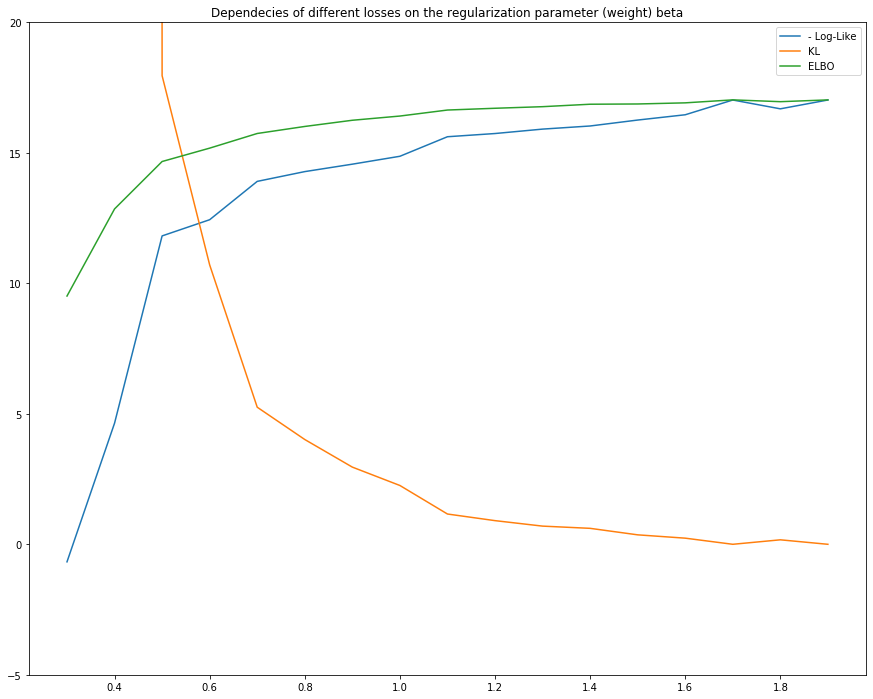

In [7]:
plt.ylim(-5,20)
plt.plot(beta_loss['beta'], beta_loss['mean_loglik'], label='- Log-Like')
plt.plot(beta_loss['beta'], beta_loss['mean_KL'], label='KL')
plt.plot(beta_loss['beta'], beta_loss['elbo'], label='ELBO')
plt.legend()
plt.title('Dependecies of different losses on the regularization parameter (weight) beta')

In [8]:
#bestidx = 17
bestidx = 70
learning_rate = model_results.iloc[bestidx,5]

mod_name = model_results.iloc[bestidx,0]
#mod_name = 'mvn_test'
path = save_dir + mod_name

vae, encoder, decoder = load_vae(path, learning_rate)
latent_dim = encoder.output.event_shape[0]

# Talent
Load

learning_rate = 0.01

mod_name = 'talent_vae_model'
path = 'saved_models/talent_vae_model'

vae, encoder, decoder = load_vae(path, learning_rate)
latent_dim = encoder.output.event_shape[0]

In [52]:
##### LEARN #####

#model_results = pd.read_csv(save_dir + '/model_results.csv', index_col=False)

pretrain_epochs = 500
batch_size = 256
inter1_dim = 8
inter2_dim = 0
latent_dim = 4
learning_rate = 0.01
callback = EarlyStopping(monitor="loss", min_delta=0.0001, patience=20)
beta = 1
original_dim = df.shape[1]


result_dict = []
vae, encoder, decoder, mod = learn(df, inter1_dim, inter2_dim, latent_dim,
                                   beta, learning_rate, result_dict,
                                   callback, pretrain_epochs, batch_size)

Train on 6522 samples
Epoch 1/500
6522/6522 [==============================] - 3s 484us/sample - loss: 20.6924
Epoch 2/500
6522/6522 [==============================] - 0s 22us/sample - loss: 17.7367
Epoch 3/500
6522/6522 [==============================] - 0s 20us/sample - loss: 17.3232
Epoch 4/500
6522/6522 [==============================] - 0s 20us/sample - loss: 17.1650
Epoch 5/500
6522/6522 [==============================] - 0s 20us/sample - loss: 17.0823
Epoch 6/500
6522/6522 [==============================] - 0s 22us/sample - loss: 17.0420
Epoch 7/500
6522/6522 [==============================] - 0s 22us/sample - loss: 16.9670
Epoch 8/500
6522/6522 [==============================] - 0s 21us/sample - loss: 16.8707
Epoch 9/500
6522/6522 [==============================] - 0s 21us/sample - loss: 16.8116
Epoch 10/500
6522/6522 [==============================] - 0s 20us/sample - loss: 16.8037
Epoch 11/500
6522/6522 [==============================] - 0s 20us/sample - loss: 16.7704
Epoch 1

In [53]:
ldist = encoder(df)
assert isinstance(ldist, tfd.Distribution)
latent_mean = ldist.mean()
sd_mean = ldist.stddev()

meandist = decoder(ldist.mean())
assert isinstance(meandist, tfd.Distribution)
output_st_mean = meandist.mean()

latent_succ = encoder(df[y == 1, :])
assert isinstance(latent_succ, tfd.Distribution)
latent_fail = encoder(df[y == 0, :])
assert isinstance(latent_fail, tfd.Distribution)

output = pd.DataFrame(scaler.inverse_transform(output_st_mean))

In [54]:
print('The mean neg log likelihood of the data (without sampling) is ', -np.asarray(meandist.log_prob(df)).mean())

The mean neg log likelihood of the data (without sampling) is  13.725818


Correlations of latent dimensions

In [55]:
pd.DataFrame(np.asarray(latent_mean)).corr()

,0,1,2,3
0,1.000000,-0.263956,0.752868,-0.740570
1,-0.263956,1.000000,-0.076304,-0.089818
2,0.752868,-0.076304,1.000000,-0.887936
3,-0.740570,-0.089818,-0.887936,1.000000


KL-divergence of individual latent dimensions (calculated with mean and std of all samples of that dimension)

In [56]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(df.shape[0]), scale=1.))
kl = []
print('KL divergence per latent dimensions. Average over inputs.')
for i in range(latent_dim):
    dist_temp = tfd.Independent(tfd.Normal(loc=np.asarray(ldist.mean()[:,i]), scale=np.asarray(ldist.stddev()[:,i])))
    kl.append(np.asarray(tfp.distributions.kl_divergence(prior, dist_temp)).mean())
    print(i,kl[i])

KL divergence per latent dimensions. Average over inputs.
0 0.0013840733
1 1.714052
2 0.37570247
3 0.0010919481


In [57]:
print('In total (sum over latent dimensions) this is a KL divergence of ', np.sum(kl))

In total (sum over latent dimensions) this is a KL divergence of  2.0922303


In [58]:
encoder.layers

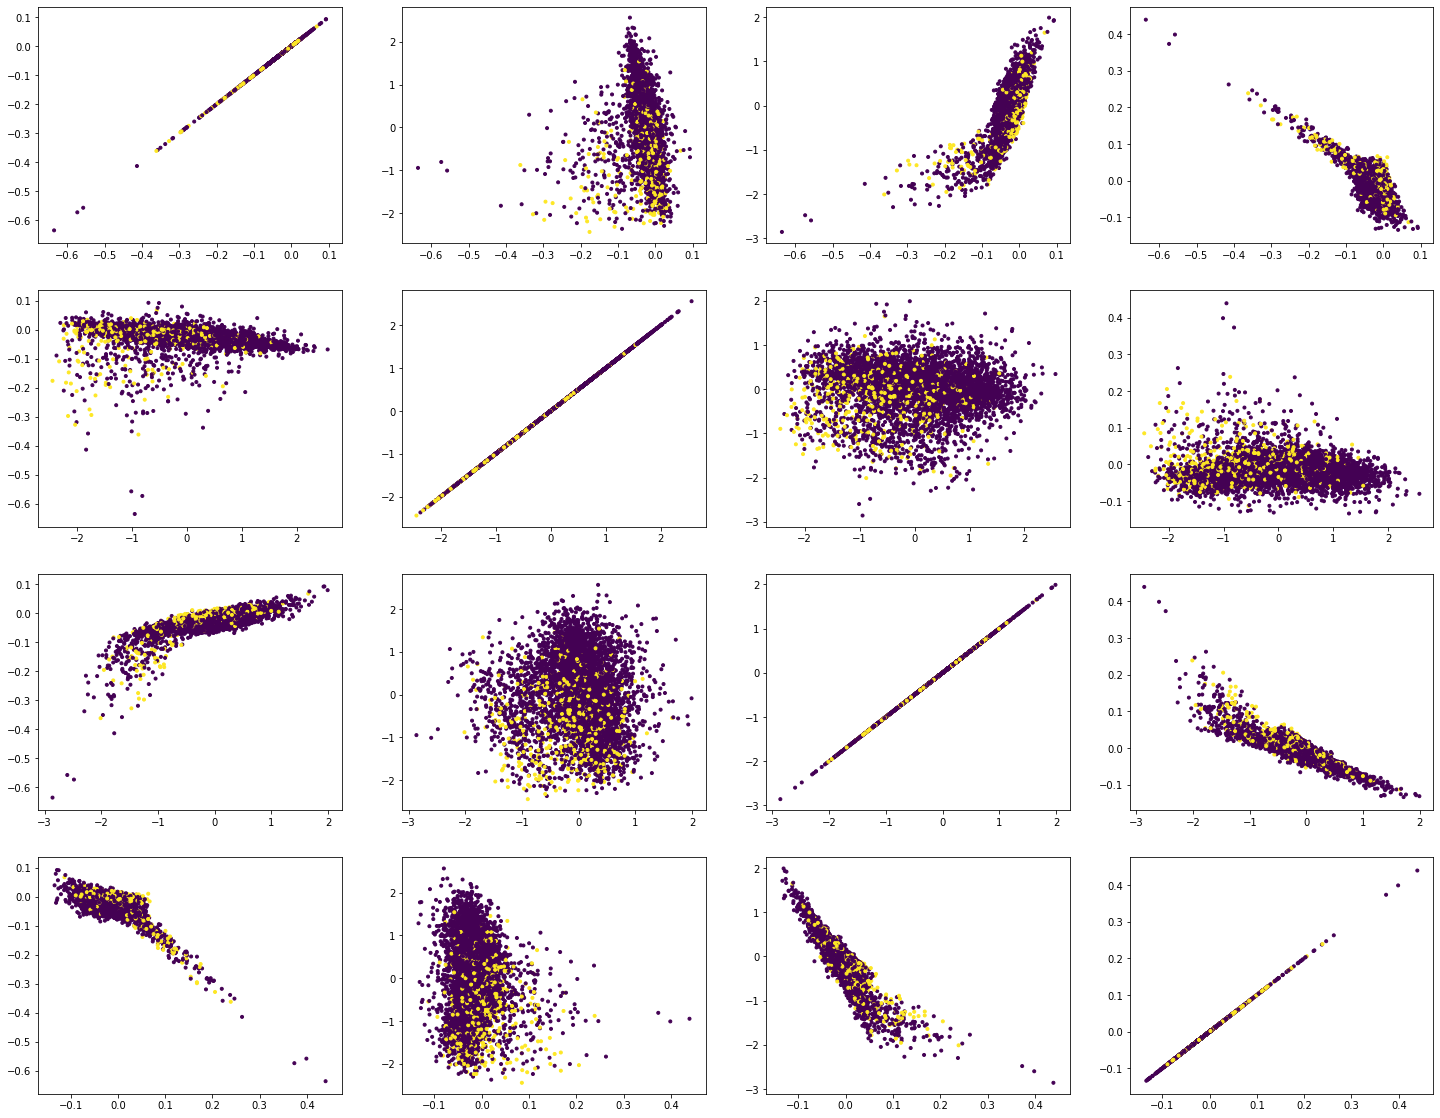

In [59]:
plot_label_clusters(latent_mean, y, latent_dim)

### T-SNE Plot of original and latent

In [16]:
#latent_embedded = TSNE(n_components=2, init='random').fit_transform(np.asarray(np.asarray(latent_mean)))

In [17]:
'''
fig, ax = plt.subplots()
scatter_x = latent_embedded[:, 0]
scatter_y = latent_embedded[:, 1]
label = y
for l in np.unique(label):
    i = np.where(label == l)
    ax.scatter(scatter_x[i], scatter_y[i], label=l, marker='o')
ax.legend()
plt.show()
'''

"\nfig, ax = plt.subplots()\nscatter_x = latent_embedded[:, 0]\nscatter_y = latent_embedded[:, 1]\nlabel = y\nfor l in np.unique(label):\n    i = np.where(label == l)\n    ax.scatter(scatter_x[i], scatter_y[i], label=l, marker='o')\nax.legend()\nplt.show()\n"

In [18]:
#df_embedded = TSNE(n_components=2, init='random').fit_transform(df)

In [19]:
#fig, ax = plt.subplots()
#scatter_x = df_embedded[:, 0]
#scatter_y = df_embedded[:, 1]
#label = y
#for l in np.unique(label):
#    i = np.where(label == l)
#    ax.scatter(scatter_x[i], scatter_y[i], label=l, marker='o')
#ax.legend()
#plt.show()

No handles with labels found to put in legend.


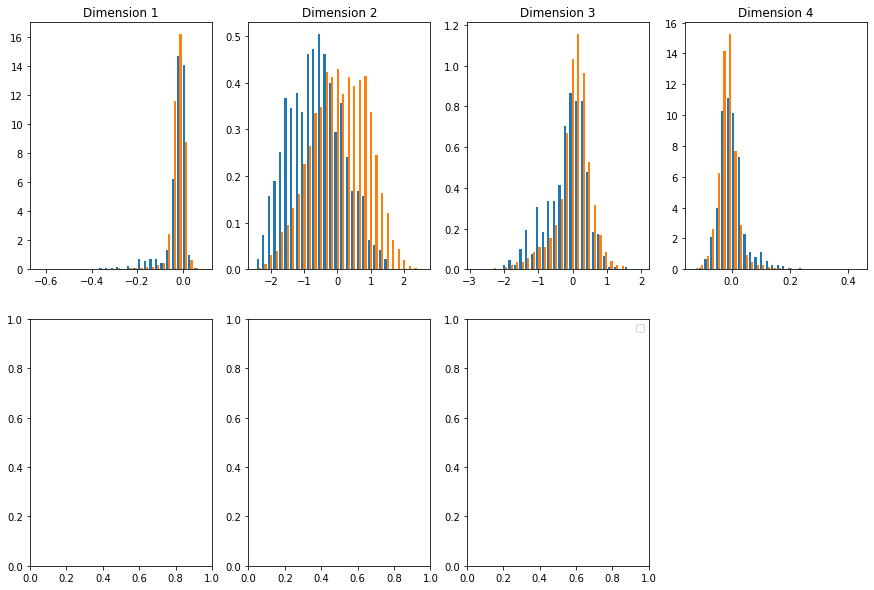

In [60]:
latent_succ_mean = latent_succ.mean()
latent_fail_mean = latent_fail.mean()

fig = plt.figure(figsize=(15,10))
axe = []
ax1 = fig.add_subplot(2,4,1)
axe.append(ax1)
ax2 = fig.add_subplot(2,4,2)
axe.append(ax2)
ax3 = fig.add_subplot(2,4,3)
axe.append(ax3)
ax4 = fig.add_subplot(2,4,4)
axe.append(ax4)
ax5 = fig.add_subplot(2,4,5)
axe.append(ax5)
ax6 = fig.add_subplot(2,4,6)
axe.append(ax6)
ax6 = fig.add_subplot(2,4,7)
axe.append(ax6)

for i in range(latent_succ_mean.shape[1]):
    if i < int(np.ceil(latent_succ_mean.shape[1]/2)):
        row = 0
    else:
        row = 1
    axe[i].hist([latent_succ_mean[:, i], latent_fail_mean[:, i]], bins=30, density=True, label=['selected','non selected'])
    axe[i].set_title('Dimension {}'.format(i+1))
    handles, labels = axe[i].get_legend_handles_labels()
plt.legend()
plt.show()

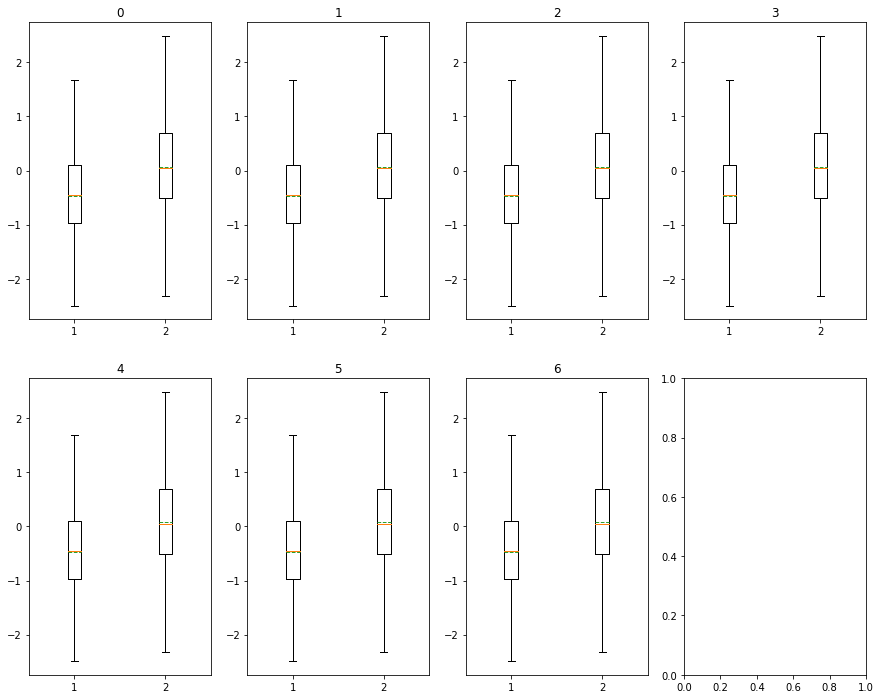

In [21]:
fig, axs = plt.subplots(2, int(np.ceil(latent_succ_mean.shape[1]/2)))
for i in range(latent_succ_mean.shape[1]):
    if i < int(np.ceil(latent_succ_mean.shape[1]/2)):
        row = 0
    else:
        row = 1
    axs[row, i%int(np.ceil(latent_succ_mean.shape[1]/2))].boxplot([latent_succ_mean[:,0],latent_fail_mean[:,0]],0,'',
                                                             showmeans=True, meanline=True)
    axs[row, i%int(np.ceil(latent_succ_mean.shape[1]/2))].set_title('{}'.format(i))
plt.show()

In [22]:
from scipy.stats import ttest_ind
for i in range(latent_dim):
    stat, p = ttest_ind(latent_succ_mean[:, i],latent_fail_mean[:, i])
    print('For dim', i+1, 'the test statistic is %.3f and p=%.3f' % (stat, p))

For dim 1 the test statistic is -13.630 and p=0.000
For dim 2 the test statistic is -11.847 and p=0.000
For dim 3 the test statistic is 10.908 and p=0.000
For dim 4 the test statistic is -6.520 and p=0.000
For dim 5 the test statistic is 11.872 and p=0.000
For dim 6 the test statistic is -10.576 and p=0.000
For dim 7 the test statistic is -17.683 and p=0.000


In [23]:
ms = np.mean(latent_succ_mean, axis=0)
ss = np.std(latent_succ_mean, axis=0)
mf = np.mean(latent_fail_mean, axis=0)
sf = np.std(latent_fail_mean, axis=0)
pd.DataFrame([ms, ss, mf, sf]).transpose()

,0,1,2,3
0,-0.464748,0.938093,0.073114,0.896148
1,0.013357,0.016849,0.024098,0.021004
2,0.051015,0.035814,0.037416,0.027619
3,0.059902,0.039645,0.069361,0.032386
4,0.058575,0.029538,0.045955,0.023674
5,-0.356607,0.829699,0.022664,0.816622
6,-0.697465,0.901606,0.027716,0.938378


Effect sizes (s = sqrt(((n1 - 1) . s1^2 + (n2 - 1) . s2^2) / (n1 + n2 - 2)))

In [24]:
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

In [25]:
d = []
for i in range(latent_dim):
    es = cohend(np.asarray(latent_succ_mean)[:,i], np.asarray(latent_fail_mean)[:,i])
    d.append(es)
    print(i,d[i])

0 -0.5976041326806405
1 -0.5194198865660409
2 0.4782712968592616
3 -0.285860321032114
4 0.5205079755394029
5 -0.4637129893071608
6 -0.7752918661082253


## Sample
Here we sample new players. By keeping all but one latent dimension constant we can see the influence of changes to one dimension.

np.random.seed(43)
sample_dim = 2
sample_ld = sampleVAE1D(decoder, latent_mean, scaler, dim=sample_dim, num_samples_other=1, tfp=True)
dim_name = 'sample_dim{}'.format(sample_dim)
title = 'Simulation of dimension {}. Plotted for all variables'.format(sample_dim)

for i in range(X.shape[-1]):
    plt.plot(sample_ld[dim_name], sample_ld['pred_or{}'.format(i)], label=X.columns[i])
plt.legend()
plt.title(title)
plt.show()

In [61]:
np.random.seed(43)
dim_select = np.arange(0, latent_dim, 1)
samples = []
for i in dim_select:
    sample_ld = sampleVAE1D(decoder, latent_mean, scaler, dim=i, num_samples_other=1, tfp=True)
    dim_name = 'sample_dim{}'.format(i)
    title = 'Dimension {}'.format(i+1)
    samples.append([sample_ld, dim_name, title])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



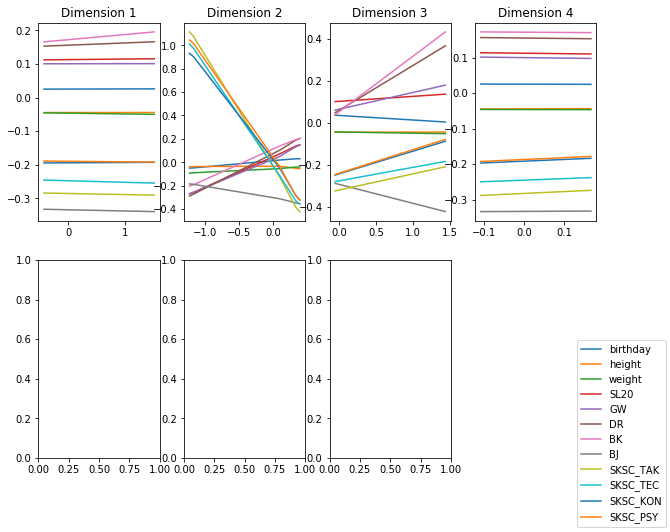

In [62]:
fig = plt.figure(figsize=(10,8))
axe = []
ax1 = fig.add_subplot(2,4,1)
axe.append(ax1)
ax2 = fig.add_subplot(2,4,2)
axe.append(ax2)
ax3 = fig.add_subplot(2,4,3)
axe.append(ax3)
ax4 = fig.add_subplot(2,4,4)
axe.append(ax4)
ax5 = fig.add_subplot(2,4,5)
axe.append(ax5)
ax6 = fig.add_subplot(2,4,6)
axe.append(ax6)
ax7 = fig.add_subplot(2,4,7)
axe.append(ax7)

for sample in range(len(samples)):
    sample_ld = samples[sample][0]
    dim_name = samples[sample][1]
    title = samples[sample][2]
    if sample < int(np.ceil(len(samples)/2)):
        row = 0
    else:
        row = 1
    for i in range(X.shape[-1]):
        axe[sample].plot(sample_ld[dim_name], sample_ld['pred_or{}'.format(i)], label=X.columns[i])
    axe[sample].set_title(title)
    handles, labels = axe[sample].get_legend_handles_labels()

fig.legend(handles, labels, loc='lower right')
plt.show()

sample_dim = 0
sample_ld = sampleVAE1D(decoder, latent_mean, scaler, dim=sample_dim, num_samples_other=1, tfp=True)
slopes = sample_slopes(sample_ld, sample_dim=sample_dim, latent_dim=latent_dim, original_dim=df.shape[1], names=X.columns)

In [63]:
slopes_list = []
for i in range(latent_dim):
    sample_ld = sampleVAE1D(decoder, latent_mean, scaler, dim=i, num_samples_other=1, tfp=True)
    slope = sample_slopes(sample_ld, sample_dim=i, latent_dim=latent_dim, original_dim=df.shape[1], names=X.columns)
    slopes_list.append(slope.iloc[:,1])
slopes = pd.concat(slopes_list, axis=1)
slopes

,m_dim0,m_dim1,m_dim2,m_dim3
birthday,0.000,0.052,-0.022,-0.003
height,0.000,-0.005,0.001,0.004
weight,-0.002,0.031,-0.006,-0.002
SL20,0.002,0.263,0.024,-0.012
GW,0.000,0.253,0.079,-0.014
DR,0.007,0.303,0.213,-0.012
BK,0.015,0.259,0.263,-0.007
BJ,-0.004,-0.102,-0.090,0.005
SKSC_TAK,-0.003,-0.963,0.077,0.052
SKSC_TEC,-0.005,-0.865,0.064,0.043


In [29]:
slopes.to_latex(escape=False)

'\\begin{tabular}{lrrrrrrr}\n\\toprule\n{} &  m_dim0 &  m_dim1 &  m_dim2 &  m_dim3 &  m_dim4 &  m_dim5 &  m_dim6 \\\\\n\\midrule\nbirthday &   0.213 &  -0.009 &   0.002 &  -0.002 &  -0.000 &   0.031 &   0.044 \\\\\nheight   &  -0.767 &   0.030 &  -0.009 &   0.003 &   0.001 &  -0.013 &  -0.006 \\\\\nweight   &  -0.655 &   0.024 &  -0.007 &   0.003 &   0.003 &   0.043 &   0.019 \\\\\nSL20     &   0.071 &  -0.009 &   0.001 &  -0.003 &   0.004 &   0.201 &   0.237 \\\\\nGW       &  -0.135 &  -0.002 &  -0.001 &  -0.002 &   0.007 &   0.309 &   0.237 \\\\\nDR       &  -0.096 &  -0.010 &   0.001 &  -0.003 &   0.013 &   0.511 &   0.275 \\\\\nBK       &   0.008 &  -0.014 &   0.002 &  -0.003 &   0.013 &   0.515 &   0.190 \\\\\nBJ       &  -0.012 &   0.004 &  -0.001 &   0.001 &  -0.004 &  -0.166 &  -0.069 \\\\\nSKSC_TAK &   0.058 &   0.000 &   0.007 &   0.011 &   0.012 &   0.058 &  -0.784 \\\\\nSKSC_TEC &  -0.131 &   0.007 &   0.004 &   0.010 &   0.011 &   0.036 &  -0.757 \\\\\nSKSC_KON &   0.059 &

In [64]:
variances = []
for i in range(latent_dim):
    sample_ld_temp = sampleVAE1D(decoder, latent_mean, scaler, dim=i, num_samples_other=1, tfp=True)
    out_temp = sample_ld_temp.iloc[:,latent_dim:(latent_dim+df.shape[1])].std()
    variances.append(out_temp)
stds = pd.concat(variances, axis=1)
stds.index = X.columns

In [65]:
# Compare to pca
from statsmodels.multivariate.pca import PCA
pca = PCA(X, ncomp=4)
loadings = pca.loadings

[Text(0.5, 1, 'PCA loadings')]

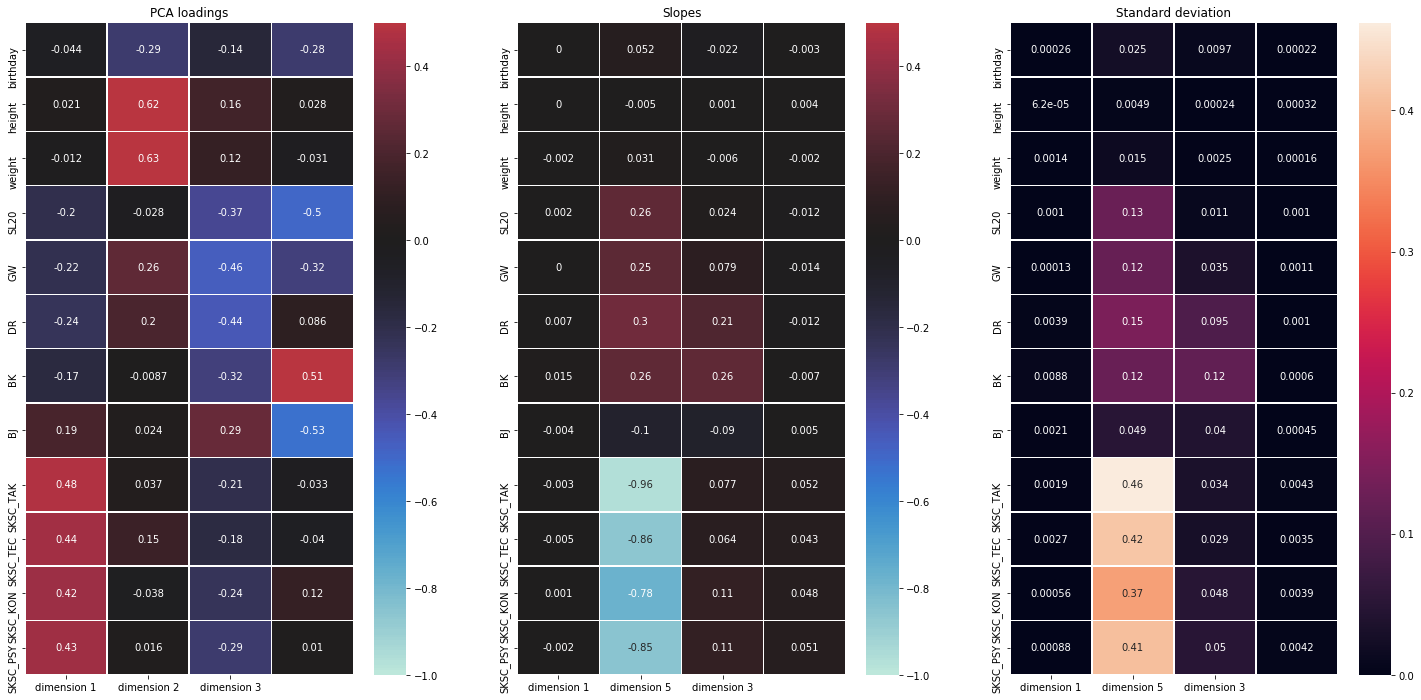

In [67]:
fig, axs = plt.subplots(1,3, figsize=(25,12))

sns.heatmap(ax=axs[1], data=slopes, annot=True, linewidths=0.5, vmin=-1, vmax=+0.5, center=0, xticklabels=["dimension 1", "dimension 5","dimension 3"]).set(title='Slopes')
sns.heatmap(ax=axs[2], data=stds, annot=True, linewidths=0.5, vmin=0, vmax=np.amax(np.asarray(stds)), xticklabels=["dimension 1", "dimension 5","dimension 3"]).set(title='Standard deviation')
sns.heatmap(ax=axs[0], data=loadings.iloc[:,[0,1,2,3]], annot=True, linewidths=0.5, vmin=-1, vmax=0.5, center=0, xticklabels=["dimension 1", "dimension 2","dimension 3"]).set(title='PCA loadings')

[Text(0.5, 1, 'PCA loadings')]

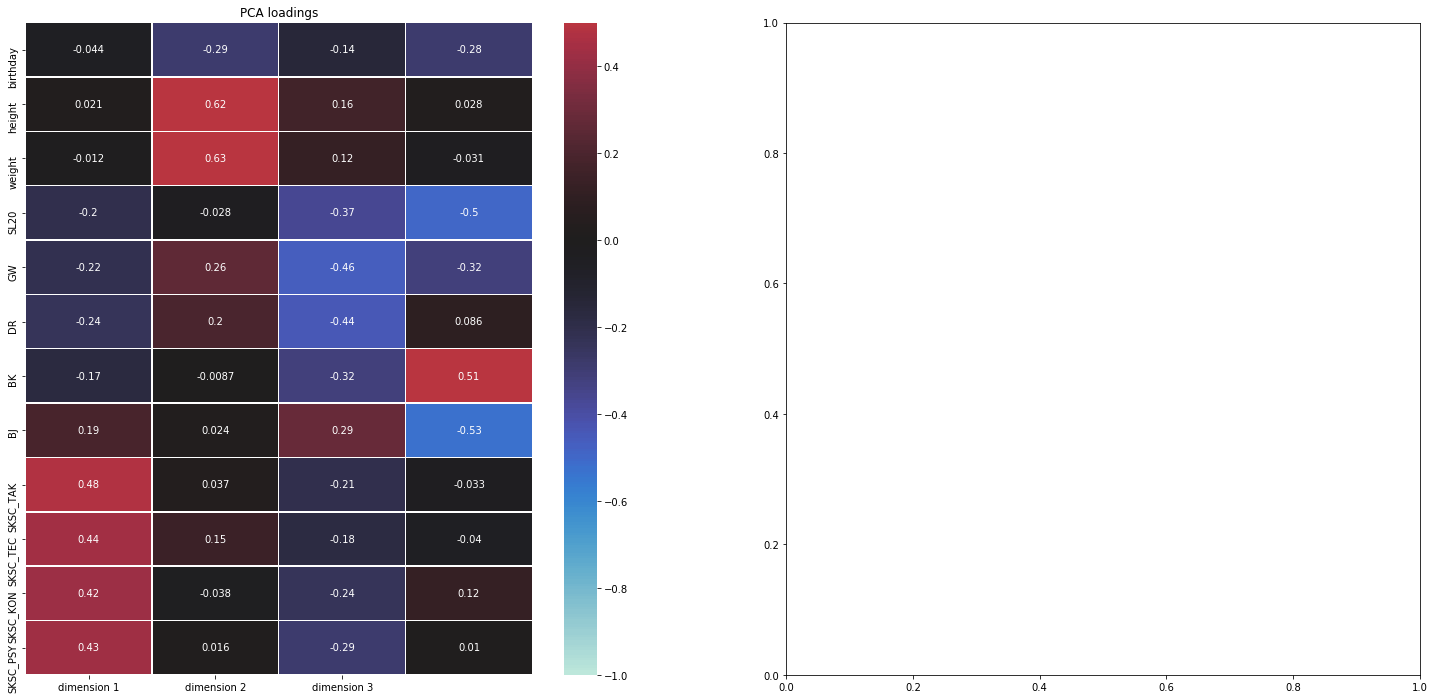

In [40]:
#fig, axs = plt.subplots(1,2, figsize=(25,12))

#sns.heatmap(ax=axs[1], data=slopes.iloc[:,[6,0,5]], annot=True, linewidths=0.5, vmin=-1, vmax=+0.5, center=0, xticklabels=["dimension 7", "dimension 1","dimension 6"]).set(title='Slopes')
fig, axs = plt.subplots(1,2, figsize=(25,12))
sns.heatmap(ax=axs[0], data=loadings.iloc[:,[0,1,2,3]], annot=True, linewidths=0.5, vmin=-1, vmax=0.5, center=0, xticklabels=["dimension 1", "dimension 2","dimension 3"]).set(title='PCA loadings')

# Discimination properties

In [93]:
dim_disc = np.argmax(kl)
dim_disc = 4

In [94]:
temp = pd.concat([pd.DataFrame(np.asarray(latent_mean)[:,dim_disc]),pd.DataFrame(y)],axis=1)
min = temp.iloc[:,0].min()
max = temp.iloc[:,0].max()

freqs = []
for th in np.arange(min, max, 0.1):
    freq_succ = temp[temp.iloc[:,0]<th].iloc[:,1].sum()/y.sum()
    freq_total = temp[temp.iloc[:,0]<th].iloc[:,1].sum()/temp.shape[0]
    n = temp[temp.iloc[:,0]<th].shape[0]
    freqs.append([th, freq_succ, freq_total, n])
cols = ['th', 'frequency_succ', 'frequency_total', 'n']
freqframe = pd.DataFrame(freqs, columns=cols)

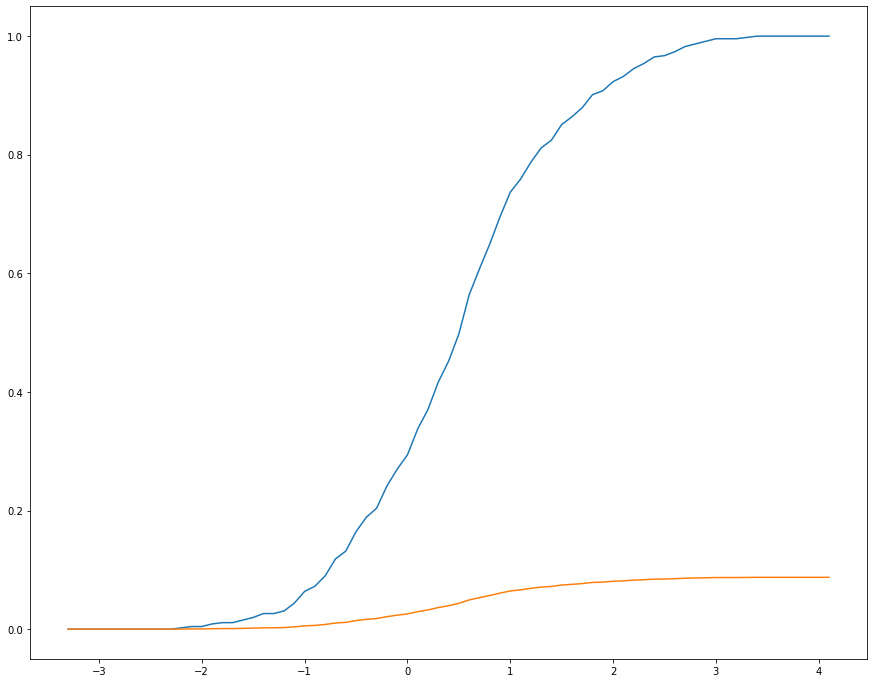

In [95]:
plt.plot(freqframe['th'], freqframe['frequency_succ'])
plt.plot(freqframe['th'], freqframe['frequency_total'])

In [96]:
t = np.arange(min, max+0.1, 0.1)
bins = []
for i in t:
    freq_bin = temp[(temp.iloc[:,0]>=i) & (temp.iloc[:,0]<(i+1))].iloc[:,1].sum()/y.sum()
    freq_bin_tot = temp[(temp.iloc[:,0]>=i) & (temp.iloc[:,0]<(i+1))].iloc[:,1].sum()/temp[(temp.iloc[:,0]>=i) & (temp.iloc[:,0]<(i+1))].iloc[:,1].shape[0]
    n_bin = temp[(temp.iloc[:,0]>=i) & (temp.iloc[:,0]<(i+1))].shape[0]
    n_succ_bin = y[(temp.iloc[:,0]>=i) & (temp.iloc[:,0]<(i+1))].sum()
    bins.append([i, freq_bin, freq_bin_tot, n_bin, n_succ_bin])
bins = pd.DataFrame(np.asarray(bins), columns=['latent_dim', 'frequency of succ in bin', 'total frequency in bin', 'athletes in bin', 'successful athletes in bin'])

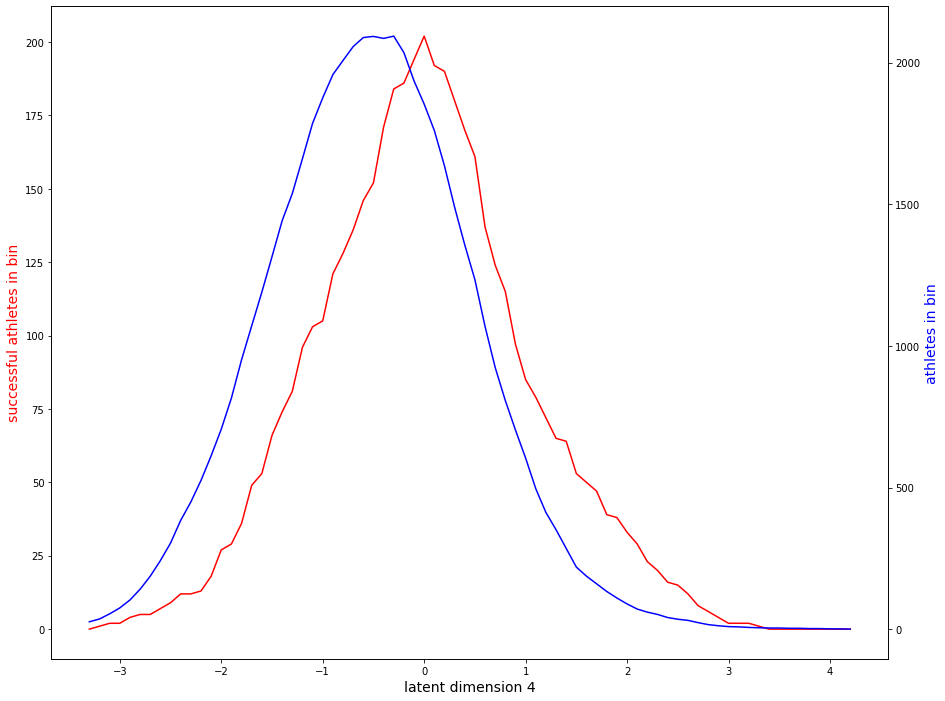

In [97]:
fig, ax = plt.subplots()
plt.plot(bins['latent_dim'], bins['successful athletes in bin'], color='red')
ax.set_xlabel('latent dimension {}'.format(dim_disc),fontsize=14)
ax.set_ylabel('successful athletes in bin', color='red', fontsize=14)

ax2=ax.twinx()
ax2.plot(bins['latent_dim'], bins['athletes in bin'], color='blue')
ax2.set_ylabel('athletes in bin', color='blue',fontsize=14)
plt.show()

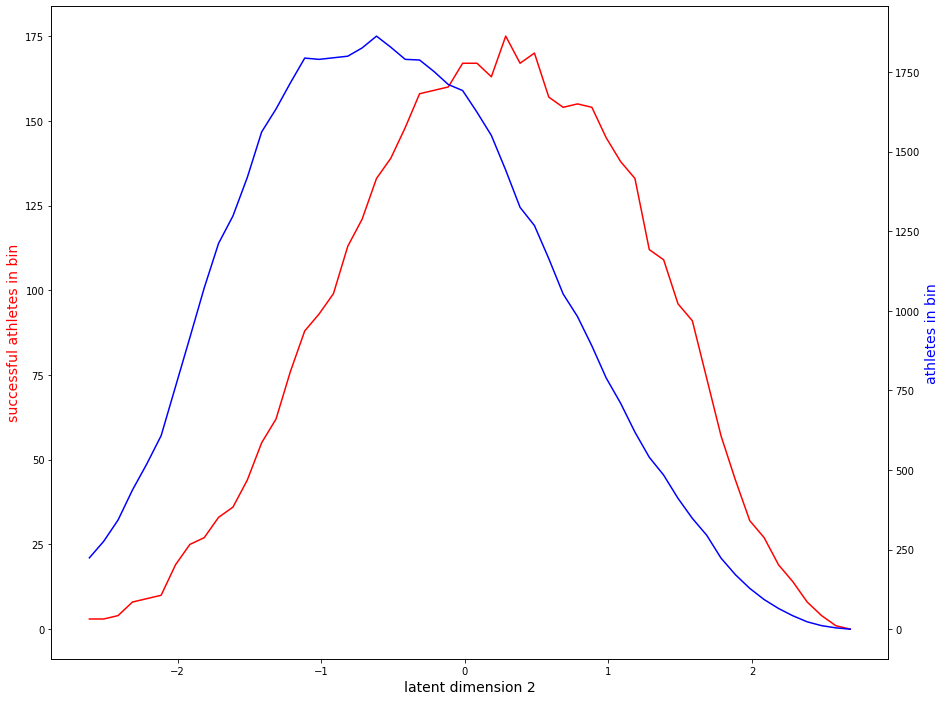

In [87]:
t = np.arange(min, max+0.1, 0.1)
bins2 = []
for i in t:
    freq_bin = temp[(temp.iloc[:,0]>=i) & (temp.iloc[:,0]<(i+1))].iloc[:,1].sum()/y.sum()
    freq_bin_tot = temp[(temp.iloc[:,0]>=i) & (temp.iloc[:,0]<(i+1))].iloc[:,1].sum()/temp[(temp.iloc[:,0]>=i) & (temp.iloc[:,0]<(i+1))].iloc[:,1].shape[0]
    n_bin = temp[(temp.iloc[:,0]>=i) & (temp.iloc[:,0]<(i+1))].shape[0]
    n_succ_bin = y[(temp.iloc[:,0]>=i) & (temp.iloc[:,0]<(i+1))].sum()
    bins2.append([i, freq_bin, freq_bin_tot, n_bin, n_succ_bin])
bins2 = pd.DataFrame(np.asarray(bins), columns=['latent_dim', 'frequency of succ in bin', 'total frequency in bin', 'athletes in bin', 'successful athletes in bin'])
fig, ax = plt.subplots()
plt.plot(bins2['latent_dim'], bins2['successful athletes in bin'], color='red')
ax.set_xlabel('latent dimension {}'.format(2),fontsize=14)
ax.set_ylabel('successful athletes in bin', color='red', fontsize=14)

ax2=ax.twinx()
ax2.plot(bins2['latent_dim'], bins2['athletes in bin'], color='blue')
ax2.set_ylabel('athletes in bin', color='blue',fontsize=14)
plt.show()

## Latent clustering

In [113]:
# select dimensions
selected_dim = pd.DataFrame(np.asarray(latent_mean)).iloc[:,[0,5,6]]

In [114]:
def n_clusters(data, max_range, method='elbow'):
    temp = []
    for k in range(1, max_range+1):
        min_range=1
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        temp.append(kmeans.inertia_)  # interia_ = total WSS (within-cluster sum of square)

    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(min_range, max_range+1), temp)
    plt.grid(True)
    plt.title(method)        # vllt 2?

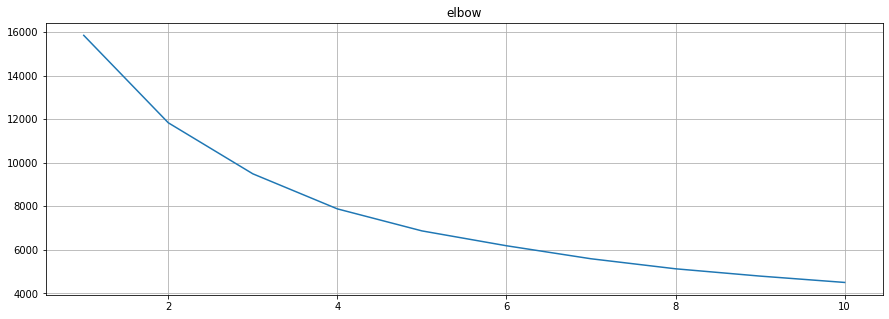

In [115]:
n_clusters(selected_dim, 10, method='elbow')
# maybe 2

In [118]:
dat_kmeans = selected_dim.copy()
kmeans = KMeans(n_clusters=2)
kmeans_model = kmeans.fit(dat_kmeans)
kmeans_labels = kmeans_model.predict(dat_kmeans)
dat_kmeans['km_label'] = kmeans_labels

In [119]:
cl_result = X_full.copy()
cl_result['km_label'] = kmeans_labels
cl_result['dim1'] = dat_kmeans.iloc[:,0]
cl_result['dim6'] = dat_kmeans.iloc[:,1]
cl_result['dim7'] = dat_kmeans.iloc[:,2]
cl_result['LZ'] = y

In [125]:
dat_0 = cl_result[cl_result['km_label']==0]
dat_1 = cl_result[cl_result['km_label']==1]
kmeans_describe = pd.concat([dat_0.describe().iloc[1:3,:].T,dat_1.describe().iloc[1:3,:].T], axis=1)
kmeans_describe

,mean,std,mean,std
birthday,165.733,102.159,152.749,101.807
height,150.362,6.774,150.835,6.778
weight,38.900,5.480,38.986,5.532
SL20,3.665,0.159,3.600,0.152
GW,8.436,0.401,8.277,0.377
DR,11.209,0.767,10.823,0.670
BK,10.490,1.377,9.901,1.210
BJ,1.935,2.276,3.468,3.820
SKSC_TAK,1.062,0.336,2.013,0.394
SKSC_TEC,1.004,0.384,1.791,0.435


In [126]:
kmeans_describe.round(2).to_latex(escape=False)

'\\begin{tabular}{lrrrr}\n\\toprule\n{} &    mean &     std &    mean &     std \\\\\n\\midrule\nbirthday &  165.73 &  102.16 &  152.75 &  101.81 \\\\\nheight   &  150.36 &    6.77 &  150.83 &    6.78 \\\\\nweight   &   38.90 &    5.48 &   38.99 &    5.53 \\\\\nSL20     &    3.66 &    0.16 &    3.60 &    0.15 \\\\\nGW       &    8.44 &    0.40 &    8.28 &    0.38 \\\\\nDR       &   11.21 &    0.77 &   10.82 &    0.67 \\\\\nBK       &   10.49 &    1.38 &    9.90 &    1.21 \\\\\nBJ       &    1.94 &    2.28 &    3.47 &    3.82 \\\\\nSKSC_TAK &    1.06 &    0.34 &    2.01 &    0.39 \\\\\nSKSC_TEC &    1.00 &    0.38 &    1.79 &    0.44 \\\\\nSKSC_KON &    1.31 &    0.60 &    2.24 &    0.57 \\\\\nSKSC_PSY &    1.33 &    0.49 &    2.24 &    0.49 \\\\\nkm_label &    0.00 &    0.00 &    1.00 &    0.00 \\\\\ndim1     &    0.05 &    0.91 &   -0.01 &    0.91 \\\\\ndim6     &    0.05 &    0.78 &   -0.08 &    0.87 \\\\\ndim7     &    0.68 &    0.54 &   -0.89 &    0.57 \\\\\nLZ       &    0.04 &   

In [146]:
from scipy.stats import ttest_ind
for i in range(17):
    stat, p = ttest_ind(dat_0.iloc[:, i],dat_1.iloc[:, i])
    print('For', dat_0.columns[i], 'the test statistic is %.3f and p=%.3f' % (stat, p))

For birthday the test statistic is 5.120 and p=0.000
For height the test statistic is -2.808 and p=0.005
For weight the test statistic is -0.632 and p=0.528
For SL20 the test statistic is 16.768 and p=0.000
For GW the test statistic is 16.380 and p=0.000
For DR the test statistic is 21.423 and p=0.000
For BK the test statistic is 18.153 and p=0.000
For BJ the test statistic is -20.037 and p=0.000
For SKSC_TAK the test statistic is -105.131 and p=0.000
For SKSC_TEC the test statistic is -77.540 and p=0.000
For SKSC_KON the test statistic is -63.094 and p=0.000
For SKSC_PSY the test statistic is -74.615 and p=0.000
For km_label the test statistic is -inf and p=0.000
For dim1 the test statistic is 2.653 and p=0.008
For dim6 the test statistic is 6.242 and p=0.000
For dim7 the test statistic is 114.035 and p=0.000
For LZ the test statistic is -14.494 and p=0.000


In [152]:
con_tab = np.array([[np.sum(dat_0.iloc[:,16]),dat_0.shape[0]-np.sum(dat_0.iloc[:,16])],[np.sum(dat_1.iloc[:,16]),dat_1.shape[0]-np.sum(dat_1.iloc[:,16])]])

In [153]:
con_tab

array([[ 148, 3400],
       [ 422, 2552]])

In [158]:
from scipy.stats import chi2_contingency
chi2, p, df, expect = chi2_contingency(con_tab)
print('chi_square=',chi2.round(2), 'p-value=',p.round(2),'df=',df)

chi_square= 202.33 p-value= 0.0 df= 1


### log reg

In [121]:
import statsmodels.api as sm

latent_logit = selected_dim.copy()
latent_logit['const'] = np.ones(latent_logit.shape[0])
# building the model and fitting the data
log_reg = sm.Logit(y, latent_logit).fit()

Optimization terminated successfully.
         Current function value: 0.253151
         Iterations 7


In [122]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6522
Model:                          Logit   Df Residuals:                     6518
Method:                           MLE   Df Model:                            3
Date:                Mon, 19 Sep 2022   Pseudo R-squ.:                  0.1461
Time:                        11:09:49   Log-Likelihood:                -1651.1
converged:                       True   LL-Null:                       -1933.6
Covariance Type:            nonrobust   LLR p-value:                3.730e-122
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.6780      0.052    -13.006      0.000      -0.780      -0.576
5             -0.4737      0.053     -8.923      0.000      -0.578      -0.370
6             -0.8232      0.051    -16.108      0.0